In [1]:
# uncomment to install dependencies
!pip install lightning

In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

# change to correct working directory
import os
os.chdir("/content/drive/MyDrive/repositories/deepfake-detection")
os.listdir() # verify content

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['README.md',
 'src',
 'environment.yml',
 '.git',
 '.gitignore',
 'config.py',
 '__pycache__',
 'playground']

In [3]:
# import library dependencies
import io
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import cv2
from PIL import Image
from itertools import islice
import tqdm

In [4]:
# import local dependencies
from src.adapters.datasets.wilddeepfake import load_streaming_dataset, create_data_loaders
from src.transforms.ela import ela
import config

In [5]:
dataset_name = "xingjunm/WildDeepfake"
max_samples = 15000  # For quick development, remove for full dataset
batch_size = 16
num_workers = 2
seed = config.SEED
save_path = 'models/mobilenet_deepfake.pth'

# Set seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset and create loaders
datasets = load_streaming_dataset(
    dataset_name,
    max_samples=max_samples,
    seed=seed
)
train_loader, val_loader, test_loader = create_data_loaders(
    datasets,
    batch_size=batch_size,
    num_workers=num_workers
)

Using device: cpu
Loading streaming dataset: xingjunm/WildDeepfake


Resolving data files:   0%|          | 0/963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

In [6]:
next(iter(datasets[0]))

{'png': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 '__key__': './154/fake/198/1675',
 '__url__': 'hf://datasets/xingjunm/WildDeepfake@f3835aaf281dd9f8d79b51c4e02f050d3f7af0b4/deepfake_in_the_wild/fake_train/154.tar.gz',
 'label': 1}

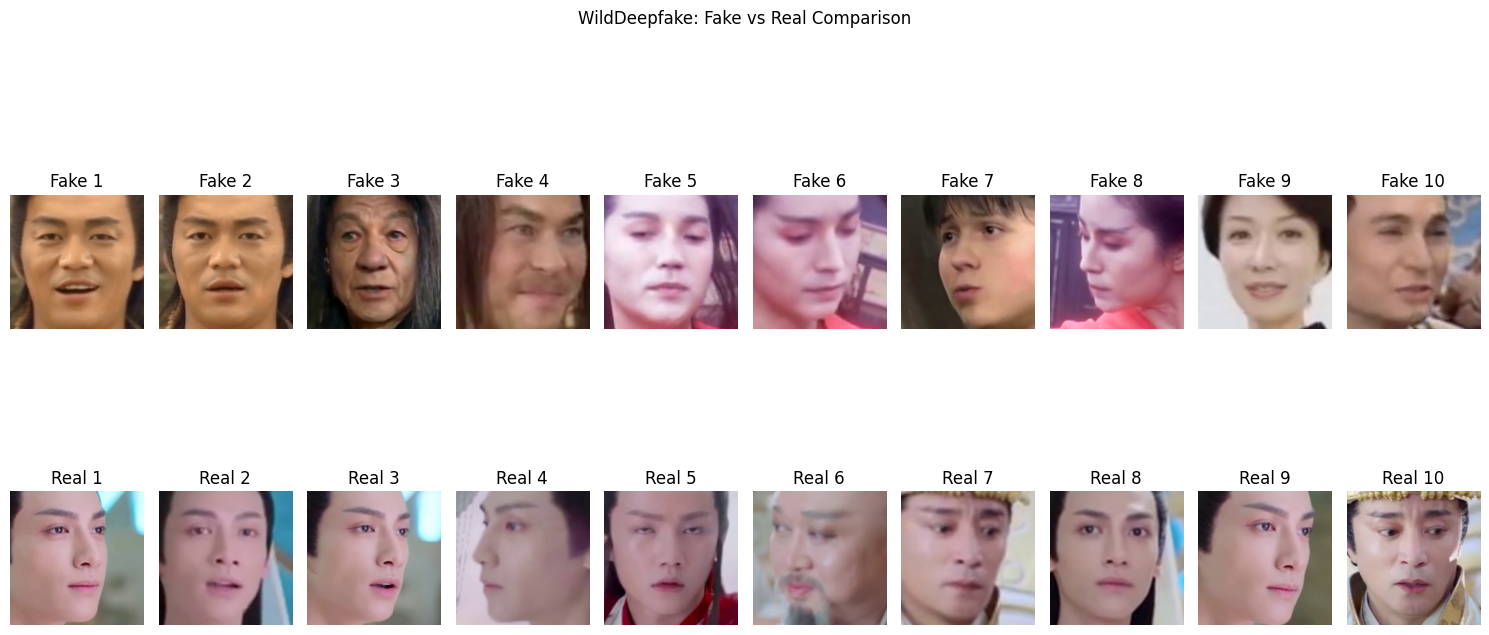

In [7]:
def compare_fake_vs_real(dataset, num_pairs=10):
    """Display fake and real images side by side"""
    fake_samples = []
    real_samples = []

    # Collect samples
    for sample in dataset:
        label = sample["label"]
        if label == 1 and len(fake_samples) < num_pairs:
            fake_samples.append(sample)
        elif label == 0 and len(real_samples) < num_pairs:
            real_samples.append(sample)

        if len(fake_samples) == num_pairs and len(real_samples) == num_pairs:
            break

    fig, axes = plt.subplots(2, num_pairs, figsize=(15, 8))

    # Display fake images in top row
    for i, sample in enumerate(fake_samples):
        axes[0, i].imshow(sample['png'])
        axes[0, i].set_title(f"Fake {i+1}")
        axes[0, i].axis('off')

    # Display real images in bottom row
    for i, sample in enumerate(real_samples):
        axes[1, i].imshow(sample['png'])
        axes[1, i].set_title(f"Real {i+1}")
        axes[1, i].axis('off')

    plt.suptitle("WildDeepfake: Fake vs Real Comparison")
    plt.tight_layout()
    plt.show()

    return fake_samples, real_samples

fake_samples, real_samples = compare_fake_vs_real(datasets[0])

In [8]:
def rpa(ela_image):
    """
    Performs Residual Pixel Analysis (RPA) on an ELA image.

    Args:
        ela_image (np.array): The ELA image.

    Returns:
        tampered (bool): True if the image is tampered, False otherwise.
    """
    # Calculate the standard deviation of the ELA image
    stddev = np.std(ela_image)

    # Define the threshold for detecting tampered images
    threshold = 0.5

    # If the standard deviation is greater than the threshold, the image is tampered
    tampered = stddev > threshold

    return tampered

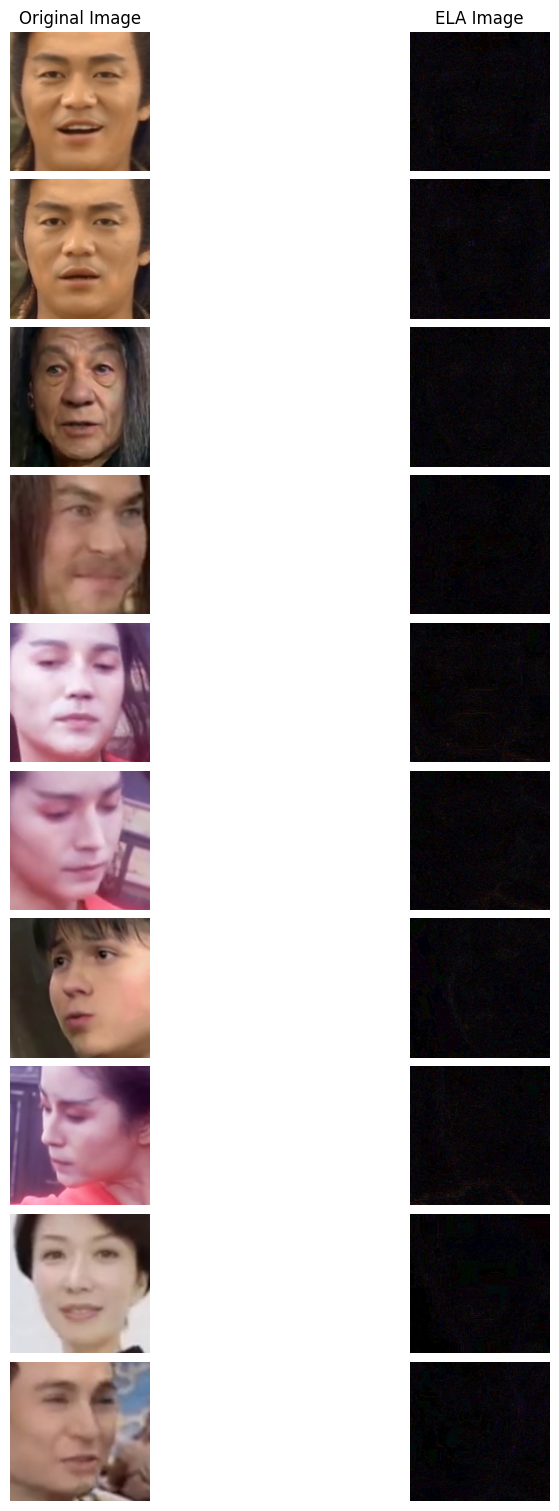

In [10]:
fig, axes = plt.subplots(len(fake_samples), 2, figsize=(8, 15), constrained_layout=True)

axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("ELA Image")

for i, sample in enumerate(fake_samples):
  original_img = sample["png"]
  ela_img = ela(original_img)
  axes[i, 0].imshow(original_img)
  axes[i, 0].axis("off")

  axes[i, 1].imshow(ela_img)
  axes[i, 1].axis("off")
plt.show()

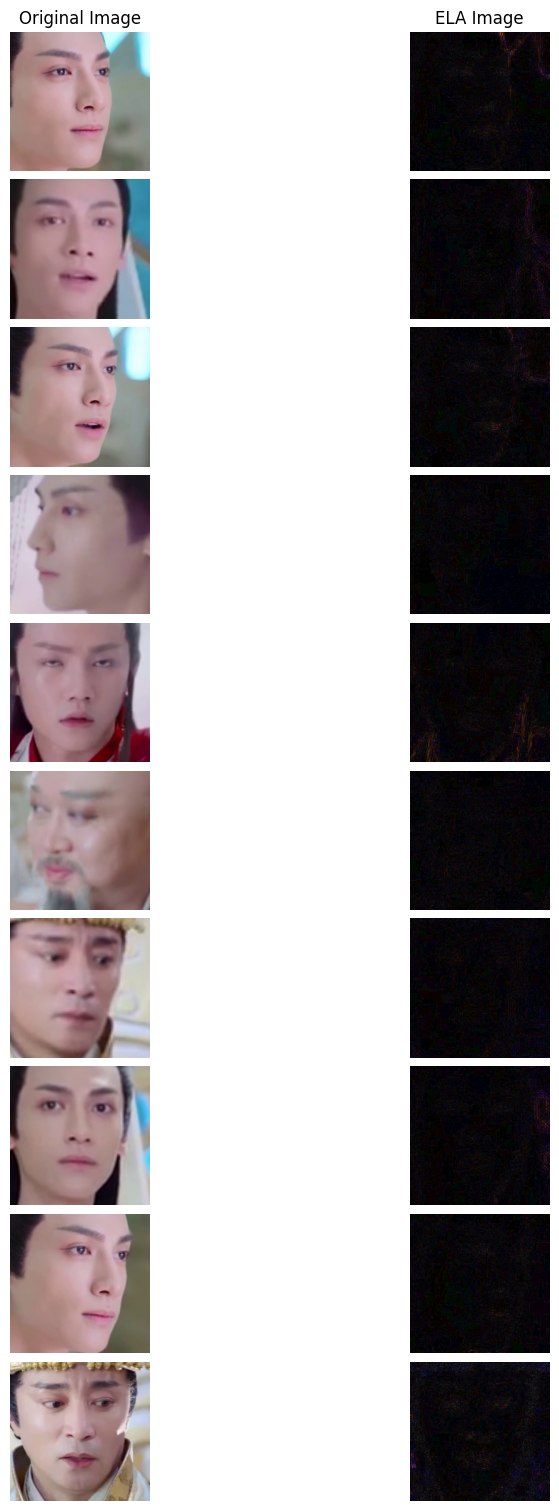

In [11]:
fig, axes = plt.subplots(len(fake_samples), 2, figsize=(8, 15), constrained_layout=True)

axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("ELA Image")
for i, sample in enumerate(real_samples):
  original_img = sample["png"]
  ela_img = ela(original_img)
  axes[i, 0].imshow(original_img)
  axes[i, 0].axis("off")

  axes[i, 1].imshow(ela_img)
  axes[i, 1].axis("off")
plt.show()

In [12]:
tp = tn = fp = fn = 0
count = 0

t = tqdm.tqdm(total=max_samples) # Initialise
for sample in datasets[0]:
  count += 1
  original_img = sample["png"]
  ela_img = ela(original_img)
  actual = sample["label"] == 1
  predicted = rpa(ela_img)
  if predicted:
    if actual: tp += 1 # deepfake detected correctly
    else: fp += 1
  else:
    if actual: fn += 1
    else: tn += 1
  t.update(1)
t.close()

 90%|████████▉ | 13479/15000 [01:47<00:12, 125.66it/s]


In [13]:
acc = (tn + tp) / (tp + fn + tn + fp) if (tp + fn + tn + fp) != 0 else 0
recall = tp / (fn + tp) if (fn + tp) != 0 else 0
precision = tp / (fp + tp) if (fp + tp) != 0 else 0
f1_score = tp / (tp + ((fp+fn)/ 2)) if (tp + ((fp+fn) / 2)) != 0 else 0

In [14]:
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.70420654351213
Recall: 1.0
Precision: 0.70420654351213
F1 Score: 0.8264333289800183
